# Prediction of air pollution with ML

We want to predict the concentration of o3 and pm25 in the atmosphere for the next 5 hours at a given location.

The data we have are the past meteorological conditions and the past concentrations at this given location.
Some data are not valid.

I assumed that the concentrations of o3 and pm25 are independent and therefore predicted separately, but it might be interesting to include one as a feature for the other to check if any correlations can be inferred.


I have designed a machine learning algorithm with LSTM network to predict the next concentrations.

The first step is to parse the data in order to have useable inputs.

The second step is to build the machine learning model and train it

The third step is to visualize the outputs and compute the performance of the model on validation data.

The fourth step is to tune the model so that we have the best hyperparameters for the given data

The fifth and final step is to implement a classical model (ARIMA), compute the performance of this model on the same data and compare the results.

The sixth step is to check for possible improvements of the algorithm

## imports

First we import all the necessary tools

In [3]:
import csv # collect data from csv files
import os # dealing with system
import matplotlib.pyplot as plt # plot resuts
import numpy as np # scientific computations
import pandas as pd # treat databases
import pickle # save and load data

from keras.preprocessing.sequence import TimeseriesGenerator # create data from time series usable by machine learning models
from keras.models import Sequential # Base of a ML model
from keras.layers import Dense # Dense (or fully connected) layer
from keras.layers import LSTM # Long Short Term Memory recurent network (very useful for time series)
from keras.models import load_model # load model from existing file
from keras.optimizers import adam_v2 # classic optimizer

from keras.callbacks import ModelCheckpoint # save best model
from keras.callbacks import ReduceLROnPlateau # learning parameters

from sklearn.metrics import mean_squared_error # mean squared error to check the accuracy of the model

from statsmodels.tsa.arima.model import ARIMA # ARIMA model (classic time series model)
from pmdarima import auto_arima # fit for the best ARIMA parameters

from keras.losses import MeanSquaredLogarithmicError # possible loss for optimization (robust to outliers)

## load the data

Now we need to load the data from the csv files and create adequate data structures.


In order to deal with invalid data, I simply duplicated the last valid value. <br>
Maybe this part could be improved by having first a model that predicts the pollutants' concentration only with the meteorological data and use this model to fill the gaps off the invalid values. Then we would compute the model with all the data.


In [60]:
class Solution():
    
    def __init__(self, path, city, particle):

        self._parse(path, city, particle)
        self._choose_file()
        self._load_data()

    def _parse(self, path, city, particle):# Specify the path to the met and stn files, 
                                            # the city to analyse and the particle to predict(all are strings).
                                            # In the python file, this is done with a real parser 
                                            # (see pollutant_inference.py)
            self.path, self.city, self.particle = path, city, particle 
            
    def _choose_file(self): # load the data paths according to the city

        if self.city == "niigata":
            self.name_met = "met_data/data_met_cams_jpn_niigata_15201220_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_niigata_15201220_pm25_o3.csv"
        elif self.city == "osaka":
            self.name_met = "met_data/data_met_cams_jpn_osaka_27227040_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_osaka_27227040_pm25_o3.csv"
        elif self.city == "tokyo":
            self.name_met = "met_data/data_met_cams_jpn_tokyo_13219010_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_tokyo_13219010_pm25_o3.csv"
        elif self.city == "boston":
            self.name_met = "met_data/data_met_cams_usa_boston_250250042_met.csv"
            self.name_stn = "stn_data/data_stations_usa_boston_250250042_pm25_o3.csv"
        elif self.city == "los_angeles":
            self.name_met = "met_data/data_met_cams_usa_los_angeles_060371103_met.csv"
            self.name_stn = "stn_data/data_stations_usa_los_angeles_060371103_pm25_o3.csv"
        elif self.city == "pheonix":
            self.name_met = "met_data/data_met_cams_usa_pheonix_040139997_met.csv"
            self.name_stn = "stn_data/data_stations_usa_pheonix_040139997_pm25_o3.csv"
        else:
            raise os.error
            
    def _load_data(self): # load the data into the variables

        self.met = {} # met is a dictionnary that contains all the meteorological data

        with open(os.path.join(self.path, self.name_met)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader)
            for row in spamreader:
                row = row[1:] # first column is an irrelevant index
                row[1:] = list(map(float, row[1:]))
                self.met[row[0]] = row[1:] # the key is the date and the value is a list of the meteorological conditions 
                                            # [temperature, humidity, precipitation, radiation, wind speed, wind direction]

        o3 = [] # list of doubles : date + concentration of o3
        pm25 = [] # list of doubles : date + concentration of pm25
        
        with open(os.path.join(self.path, self.name_stn)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader) # skip first row that is only a header
            for row in spamreader:
                newrow = []
                row = row[1:5] # skip first column that is only an index
                newrow.append(row[0].split("+00:00")[0]) # split function is used to match the date format 
                                                            # with the dates of meteorological data
                newrow.append(float(row[1]))
                if row[3] == "True": # boolean that says if the data is valid
                    if row[2] == "o3":
                        o3.append(newrow) 
                    if row[2] == "pm25":
                        pm25.append(newrow)
                else: # if the data is not valid
                    if row[2] == "o3":
                        newrow[1] = o3[-1][1] # we duplicate the last value (best estimation we have)
                        o3.append(newrow)
                    if row[2] == "pm25":
                        newrow[1] = pm25[-1][1]
                        pm25.append(newrow)
    
        self.pollutants = {"o3": pd.DataFrame(o3, columns=["date", "concentration"]), # Dictionary that contains both o3 and pm25 data
                        "pm25": pd.DataFrame(pm25, columns=["date", "concentration"])}
            
            

In [61]:
path = "C:/Users/jeffm/Desktop/projet_breezo"
city = "niigata"
particle = "o3"

S = Solution(path, city, particle)

S.pollutants

{'o3':                      date  concentration
 0     2020-01-01 00:00:00           33.0
 1     2020-01-01 01:00:00           34.0
 2     2020-01-01 02:00:00           35.0
 3     2020-01-01 03:00:00           36.0
 4     2020-01-01 04:00:00           37.0
 ...                   ...            ...
 8631  2020-12-31 19:00:00           30.0
 8632  2020-12-31 20:00:00           30.0
 8633  2020-12-31 21:00:00           26.0
 8634  2020-12-31 22:00:00           32.0
 8635  2020-12-31 23:00:00           32.0
 
 [8636 rows x 2 columns],
 'pm25':                      date  concentration
 0     2020-01-01 00:00:00            5.0
 1     2020-01-01 01:00:00            2.0
 2     2020-01-01 02:00:00            2.0
 3     2020-01-01 03:00:00            5.0
 4     2020-01-01 04:00:00            3.0
 ...                   ...            ...
 8338  2020-12-31 19:00:00            3.0
 8339  2020-12-31 20:00:00            2.0
 8340  2020-12-31 21:00:00            2.0
 8341  2020-12-31 22:00:00        

## Prepare features for the neural network

I added a function "prepare_features" to produce the inputs that will be fed to the network. <br>
Basically, at a given time t, the input is all the meteorological features and the concentration of the particle for the previous 24 hours. The output corresponds to the next 5 concentrations.

I discriminated with a boolean "use_features". If set to false, the inputs only correspond to the particle concentrations and the model doesn't use the meteorological data. <br>
This permits two things : first, to compare with the ARIMA model that doesn't take the meteorological data into account and second, to make sure that the LSTM network indeed learns from the meteorological data.

I noticed that the detection of o3 indeed improves with the meteorological data but not the detection of pm25. Maybe this has a physical explanation.



Another remark is that I only used the meteorological data from the past. It wasn't specified on the PDF whether only the pollution data had a delay, or if also the meteorological data had a delay. <br>
I considered that both had a delay but if only the pollution data have a delay, then we could improve the model by adding the meteorological up to t+5 hours.

In [62]:
class Solution():

    def __init__(self, path, city, particle):

        self._parse(path, city, particle)
        self._choose_file()
        self._load_data()

    def _parse(self, path, city, particle):# Specify the path to the met and stn files, 
                                            # the city to analyse and the particle to predict(all are strings).
                                            # In the python file, this is done with a real parser 
                                            # (see pollutant_inference.py)
            self.path, self.city, self.particle = path, city, particle 

    def _choose_file(self): # load the data paths according to the city

        if self.city == "niigata":
            self.name_met = "met_data/data_met_cams_jpn_niigata_15201220_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_niigata_15201220_pm25_o3.csv"
        elif self.city == "osaka":
            self.name_met = "met_data/data_met_cams_jpn_osaka_27227040_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_osaka_27227040_pm25_o3.csv"
        elif self.city == "tokyo":
            self.name_met = "met_data/data_met_cams_jpn_tokyo_13219010_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_tokyo_13219010_pm25_o3.csv"
        elif self.city == "boston":
            self.name_met = "met_data/data_met_cams_usa_boston_250250042_met.csv"
            self.name_stn = "stn_data/data_stations_usa_boston_250250042_pm25_o3.csv"
        elif self.city == "los_angeles":
            self.name_met = "met_data/data_met_cams_usa_los_angeles_060371103_met.csv"
            self.name_stn = "stn_data/data_stations_usa_los_angeles_060371103_pm25_o3.csv"
        elif self.city == "pheonix":
            self.name_met = "met_data/data_met_cams_usa_pheonix_040139997_met.csv"
            self.name_stn = "stn_data/data_stations_usa_pheonix_040139997_pm25_o3.csv"
        else:
            raise os.error

    def _load_data(self): # load the data into the variables

        self.met = {} # met is a dictionnary that contains all the meteorological data

        with open(os.path.join(self.path, self.name_met)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader)
            for row in spamreader:
                row = row[1:] # first column is an irrelevant index
                row[1:] = list(map(float, row[1:]))
                self.met[row[0]] = row[1:] # the key is the date and the value is a list of the meteorological conditions 
                                            # [temperature, humidity, precipitation, radiation, wind speed, wind direction]


        o3 = [] # list of doubles : date + concentration of o3
        pm25 = [] # list of doubles : date + concentration of pm25
        with open(os.path.join(self.path, self.name_stn)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader) # skip first row that is only a header
            for row in spamreader:
                newrow = []
                row = row[1:5] # skip first column that is only an index
                newrow.append(row[0].split("+00:00")[0]) # split function is used to match the date format 
                                                            # with the dates of meteorological data
                newrow.append(float(row[1]))
                if row[3] == "True": # boolean that says if the data is valid
                    if row[2] == "o3":
                        o3.append(newrow)
                    if row[2] == "pm25":
                        pm25.append(newrow)
                else: # if the data is not valid
                    if row[2] == "o3":
                        newrow[1] = o3[-1][1] # we duplicate the last value (best estimation we have)
                        o3.append(newrow)
                    if row[2] == "pm25":
                        newrow[1] = pm25[-1][1]
                        pm25.append(newrow)


        self.pollutants = {"o3": pd.DataFrame(o3, columns=["date", "concentration"]), # Dictionary that contains both o3 and pm25 data
                            "pm25": pd.DataFrame(pm25, columns=["date", "concentration"])}

    def prepare_features(self, train_prop=0.8, output_len=5, n_hours=24, use_features=True): # Prepare the features for the machine learning model

        self.use_features = use_features # boolean asking if the model takes the meteorological data in count or only the particle concentrations
        self.n_hours = n_hours # number of hours to take into account for the prediction (default is 24)
        self.output_len = output_len # number of hours to predict in the future (default is 5)

        self.data = np.array(self.pollutants[self.particle]["concentration"]) # data of the concentration of the particle
        times = np.array(self.pollutants[self.particle]["date"]) # times of the measures
        n = len(self.data)
        self.last_train = int(train_prop*n) # last index of the train set
                                                # train_prop is the proportion of training data

        self.normalizing_ratio = np.max(self.data)
        data = self.data/self.normalizing_ratio # normalizing the data

        outputs = [] # regroups the outputs : the 5 next concentrations at each time
        for i in range(n - output_len):
            output = [data[j] for j in range(i+1, i+output_len+1)]
            outputs.append(output)

        self.output_train = outputs[:self.last_train-output_len] # remove the last 5 predictions that are in the test set
        self.output_test = outputs[self.last_train:]

        if not use_features:
            self.train_features = data[:self.last_train - output_len] # since we predict 5 steps ahead, we can't predict the 5 last steps
            self.test_features = data[self.last_train:n-output_len] # same here
            self.n_features = 1 # only predict with air pollution

        else:
            features = []
            for i in range(n):
                feature = self.met[times[i]] # all the meteorological conditions
                feature.append(data[i]) # append the air pollution
                features.append(feature)

            features = features / np.max(features, axis=0) # normalizing the features

            self.train_features = features[:self.last_train-output_len] # split train and tes features
            self.test_features = features[self.last_train:len(features)-output_len]

            self.n_features = len(feature)



In [63]:
path = "C:/Users/jeffm/Desktop/projet_breezo"
city = "niigata"
particle = "o3"

S = Solution(path, city, particle)
S.prepare_features()

print("first 5 features : ", S.train_features[:5])
print("first 5 outputs : ", S.output_train[:5])

first 5 features :  [[0.90884823 0.738      0.01092233 0.01979167 0.50387141 0.68187988
  0.39759036]
 [0.91219824 0.687      0.00364078 0.15625    0.58631027 0.66924873
  0.40963855]
 [0.91442048 0.671      0.00364078 0.25       0.62433162 0.63697864
  0.42168675]
 [0.91243604 0.815      0.01456311 0.28125    0.72119868 0.72092699
  0.43373494]
 [0.90441762 0.962      0.05461165 0.22916667 0.36408571 0.89292918
  0.44578313]]
first 5 outputs :  [[0.40963855421686746, 0.42168674698795183, 0.43373493975903615, 0.4457831325301205, 0.39759036144578314], [0.42168674698795183, 0.43373493975903615, 0.4457831325301205, 0.39759036144578314, 0.40963855421686746], [0.43373493975903615, 0.4457831325301205, 0.39759036144578314, 0.40963855421686746, 0.42168674698795183], [0.4457831325301205, 0.39759036144578314, 0.40963855421686746, 0.42168674698795183, 0.42168674698795183], [0.39759036144578314, 0.40963855421686746, 0.42168674698795183, 0.42168674698795183, 0.4578313253012048]]


## Train the algorithm

Now we need a training function :

First, there is a "load" boolean that specifies if we want to load a previous model or not.

The model consists of a simple LSTM network with a dense function. <br>
From the articles I read, it seems that LSTM are the best way to predict time series. 

The reasons for this efficiency is that LSTM networks are recurrent networks that have long term connections and can therefore learn the important values from series of data that have a connection between each other like a video, a text or a time series. <br>
Classic recurrent neural networks would only take into account the few values before a given time t but the avantage of LSTM is that it takes values from a while if it's important (long term memory).


All the parameters can be fine-tuned, I uploaded the best I found, but research can still be made about the different optimizers, learning rate starting point, learning rate decreasing ratio, loss, batch size, …

To split the training and validation datasets, I chose the first 80% to be in the training set and the last 20% to be in the validation set. I can't completely randomize the data because since it's a time series, there is a continuation in the dataset. <br>
However, I think a good idea to follow up could be to split the datasets between weeks or month that would be indivisible and then randomize between these weeks or months into training and validation set. <br>
Indeed, I am afraid of overfitting over the training and the validation set that I use.

In [4]:
class Solution():

    def __init__(self, path, city, particle):

        self._parse(path, city, particle)
        self._choose_file()
        self._load_data()

    def _parse(self, path, city, particle):# Specify the path to the met and stn files, 
                                            # the city to analyse and the particle to predict(all are strings).
                                            # In the python file, this is done with a real parser 
                                            # (see pollutant_inference.py)
            self.path, self.city, self.particle = path, city, particle 

    def _choose_file(self): # load the data paths according to the city

        if self.city == "niigata":
            self.name_met = "met_data/data_met_cams_jpn_niigata_15201220_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_niigata_15201220_pm25_o3.csv"
        elif self.city == "osaka":
            self.name_met = "met_data/data_met_cams_jpn_osaka_27227040_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_osaka_27227040_pm25_o3.csv"
        elif self.city == "tokyo":
            self.name_met = "met_data/data_met_cams_jpn_tokyo_13219010_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_tokyo_13219010_pm25_o3.csv"
        elif self.city == "boston":
            self.name_met = "met_data/data_met_cams_usa_boston_250250042_met.csv"
            self.name_stn = "stn_data/data_stations_usa_boston_250250042_pm25_o3.csv"
        elif self.city == "los_angeles":
            self.name_met = "met_data/data_met_cams_usa_los_angeles_060371103_met.csv"
            self.name_stn = "stn_data/data_stations_usa_los_angeles_060371103_pm25_o3.csv"
        elif self.city == "pheonix":
            self.name_met = "met_data/data_met_cams_usa_pheonix_040139997_met.csv"
            self.name_stn = "stn_data/data_stations_usa_pheonix_040139997_pm25_o3.csv"
        else:
            raise os.error

    def _load_data(self): # load the data into the variables

        self.met = {} # met is a dictionnary that contains all the meteorological data

        with open(os.path.join(self.path, self.name_met)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader)
            for row in spamreader:
                row = row[1:] # first column is an irrelevant index
                row[1:] = list(map(float, row[1:]))
                self.met[row[0]] = row[1:] # the key is the date and the value is a list of the meteorological conditions 
                                            # [temperature, humidity, precipitation, radiation, wind speed, wind direction]


        o3 = [] # list of doubles : date + concentration of o3
        pm25 = [] # list of doubles : date + concentration of pm25
        with open(os.path.join(self.path, self.name_stn)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader) # skip first row that is only a header
            for row in spamreader:
                newrow = []
                row = row[1:5] # skip first column that is only an index
                newrow.append(row[0].split("+00:00")[0]) # split function is used to match the date format 
                                                            # with the dates of meteorological data
                newrow.append(float(row[1]))
                if row[3] == "True": # boolean that says if the data is valid
                    if row[2] == "o3":
                        o3.append(newrow)
                    if row[2] == "pm25":
                        pm25.append(newrow)
                else: # if the data is not valid
                    if row[2] == "o3":
                        newrow[1] = o3[-1][1] # we duplicate the last value (best estimation we have)
                        o3.append(newrow)
                    if row[2] == "pm25":
                        newrow[1] = pm25[-1][1]
                        pm25.append(newrow)


        self.pollutants = {"o3": pd.DataFrame(o3, columns=["date", "concentration"]), # Dictionary that contains both o3 and pm25 data
                            "pm25": pd.DataFrame(pm25, columns=["date", "concentration"])}

    def prepare_features(self, train_prop=0.8, output_len=5, n_hours=24, use_features=True): # Prepare the features for the machine learning model

        self.use_features = use_features # boolean asking if the model takes the meteorological data in count or only the particle concentrations
        self.n_hours = n_hours # number of hours to take into account for the prediction (default is 24)
        self.output_len = output_len # number of hours to predict in the future (default is 5)

        self.data = np.array(self.pollutants[self.particle]["concentration"]) # data of the concentration of the particle
        times = np.array(self.pollutants[self.particle]["date"]) # times of the measures
        n = len(self.data)
        self.last_train = int(train_prop*n) # last index of the train set
                                                # train_prop is the proportion of training data

        self.normalizing_ratio = np.max(self.data)
        data = self.data/self.normalizing_ratio # normalizing the data

        outputs = [] # regroups the outputs : the 5 next concentrations at each time
        for i in range(n - output_len):
            output = [data[j] for j in range(i+1, i+output_len+1)]
            outputs.append(output)

        self.output_train = outputs[:self.last_train-output_len] # remove the last 5 predictions that are in the test set
        self.output_test = outputs[self.last_train:]

        if not use_features:
            self.train_features = data[:self.last_train - output_len] # since we predict 5 steps ahead, we can't predict the 5 last steps
            self.test_features = data[self.last_train:n-output_len] # same here
            self.n_features = 1 # only predict with air pollution

        else:
            features = []
            for i in range(n):
                feature = self.met[times[i]] # all the meteorological conditions
                feature.append(data[i]) # append the air pollution
                features.append(feature)

            features = features / np.max(features, axis=0) # normalizing the features

            self.train_features = features[:self.last_train-output_len] # split train and tes features
            self.test_features = features[self.last_train:len(features)-output_len]

            self.n_features = len(feature)



    def train(self, load=False, batch_size=16, units=100, epochs=100): # train the ML model
                                                                        # batch size is the number of inputs fed at the same time
                                                                        # units is the number of neurons in the LSTM network

        self.load = load # load is a boolean that specify if we want to load a previous model

        if not load:

            self.generator_train = TimeseriesGenerator(self.train_features, self.output_train, length=self.n_hours, batch_size=batch_size) # generates the couples (input, output) for the time serie
            self.generator_test = TimeseriesGenerator(self.test_features, self.output_test, length=self.n_hours, batch_size=1)              # split between train and test


            model = Sequential() # initialize a neural network
            model.add(LSTM(units, activation='relu', input_shape=(self.n_hours, self.n_features))) # long short term memory layer : efficient for time series
            model.add(Dense(self.output_len)) # converge to the number of expected outputs

            model.compile(optimizer='Adam', loss="mse") # classic optimizer and loss

            model.summary()

            mcp_save = ModelCheckpoint(os.path.join(self.path, "model"), save_best_only=True, monitor='val_loss', mode='min') # save the best model according to validation loss
            reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, verbose=1, min_delta=1e-4, mode='min') # reduce learning rate if the loss hasn't decreased for too long

            model.fit(self.generator_train, validation_data = self.generator_test, epochs=epochs, callbacks=[mcp_save, reduce_lr_loss]) # train model

            with open(os.path.join(self.path, "model",'loss_history'), 'wb') as file_pi:
                pickle.dump(model.history.history, file_pi) # save loss history

            

        self.model = load_model(os.path.join(self.path, "model")) # load best model
        loss_history = pickle.load(open(os.path.join(self.path, "model",'loss_history'), "rb")) # load loss history
        self.train_loss = loss_history['loss']
        self.val_loss = loss_history['val_loss']


In [9]:
path = "C:/Users/jeffm/Desktop/projet_breezo"
city = "niigata"
particle = "o3"

S = Solution(path, city, particle)
S.prepare_features(use_features=True)
S.train()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               43200     
                                                                 
 dense_4 (Dense)             (None, 5)                 505       
                                                                 
Total params: 43,705
Trainable params: 43,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
426/430 [============================>.] - ETA: 0s - loss: 0.0192INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 11s 23ms/step - loss: 0.0191 - val_loss: 0.0087 - lr: 0.0010
Epoch 2/100
430/430 [==============================] - 7s 17ms/step - loss: 0.0128 - val_loss: 0.0223 - lr: 0.0010
Epoch 3/100
426/430 [============================>.] - ETA: 0s - loss: 0.0118INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 9s 20ms/step - loss: 0.0118 - val_loss: 0.0081 - lr: 0.0010
Epoch 4/100
429/430 [============================>.] - ETA: 0s - loss: 0.0100INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 10s 23ms/step - loss: 0.0100 - val_loss: 0.0076 - lr: 0.0010
Epoch 5/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0097 - val_loss: 0.0088 - lr: 0.0010
Epoch 6/100
428/430 [============================>.] - ETA: 0s - loss: 0.0091INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 9s 21ms/step - loss: 0.0090 - val_loss: 0.0071 - lr: 0.0010
Epoch 7/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0089 - val_loss: 0.0075 - lr: 0.0010
Epoch 8/100
429/430 [============================>.] - ETA: 0s - loss: 0.0088INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 9s 22ms/step - loss: 0.0088 - val_loss: 0.0069 - lr: 0.0010
Epoch 9/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0084 - val_loss: 0.0070 - lr: 0.0010
Epoch 10/100
425/430 [============================>.] - ETA: 0s - loss: 0.0084INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 9s 22ms/step - loss: 0.0084 - val_loss: 0.0069 - lr: 0.0010
Epoch 11/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0082 - val_loss: 0.0079 - lr: 0.0010
Epoch 12/100
428/430 [============================>.] - ETA: 0s - loss: 0.0080INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 10s 22ms/step - loss: 0.0080 - val_loss: 0.0065 - lr: 0.0010
Epoch 13/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0079 - val_loss: 0.0070 - lr: 0.0010
Epoch 14/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0078 - val_loss: 0.0069 - lr: 0.0010
Epoch 15/100
426/430 [============================>.] - ETA: 0s - loss: 0.0077INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 10s 22ms/step - loss: 0.0077 - val_loss: 0.0065 - lr: 0.0010
Epoch 16/100
430/430 [==============================] - ETA: 0s - loss: 0.0075INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 10s 22ms/step - loss: 0.0075 - val_loss: 0.0064 - lr: 0.0010
Epoch 17/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0075 - val_loss: 0.0064 - lr: 0.0010
Epoch 18/100
428/430 [============================>.] - ETA: 0s - loss: 0.0073INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 9s 22ms/step - loss: 0.0073 - val_loss: 0.0063 - lr: 0.0010
Epoch 19/100
427/430 [============================>.] - ETA: 0s - loss: 0.0073INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 10s 22ms/step - loss: 0.0073 - val_loss: 0.0062 - lr: 0.0010
Epoch 20/100
430/430 [==============================] - 8s 20ms/step - loss: 0.0075 - val_loss: 0.0086 - lr: 0.0010
Epoch 21/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0073 - val_loss: 0.0065 - lr: 0.0010
Epoch 22/100
430/430 [==============================] - 9s 21ms/step - loss: 0.0072 - val_loss: 0.0072 - lr: 0.0010
Epoch 23/100
430/430 [==============================] - 9s 20ms/step - loss: 0.0073 - val_loss: 0.0071 - lr: 0.0010
Epoch 24/100
430/430 [==============================] - 9s 20ms/step - loss: 0.0072 - val_loss: 0.0073 - lr: 0.0010
Epoch 25/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0071 - val_loss: 0.0062 - lr: 0.0010
Epoch 26/100
428/430 [============================>.] - ETA: 0s - loss: 0.0070INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 10s 22ms/step - loss: 0.0070 - val_loss: 0.0062 - lr: 0.0010
Epoch 27/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0070 - val_loss: 0.0064 - lr: 0.0010
Epoch 28/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0070 - val_loss: 0.0064 - lr: 0.0010
Epoch 29/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0070 - val_loss: 0.0066 - lr: 0.0010
Epoch 30/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0067 - val_loss: 0.0064 - lr: 0.0010
Epoch 31/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0068 - val_loss: 0.0063 - lr: 0.0010
Epoch 32/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0066 - val_loss: 0.0066 - lr: 0.0010
Epoch 33/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0067 - val_loss: 0.0063 - lr: 0.0010
Epoch 34/100
428/430 [============================>.] - ETA: 0s - loss: 0.0067
Epoch

INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 9s 22ms/step - loss: 0.0061 - val_loss: 0.0060 - lr: 3.0000e-04
Epoch 36/100
429/430 [============================>.] - ETA: 0s - loss: 0.0060INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


INFO:tensorflow:Assets written to: C:/Users/jeffm/Desktop/projet_breezo\model\assets


430/430 [==============================] - 10s 23ms/step - loss: 0.0060 - val_loss: 0.0059 - lr: 3.0000e-04
Epoch 37/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0060 - val_loss: 0.0062 - lr: 3.0000e-04
Epoch 38/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0059 - val_loss: 0.0062 - lr: 3.0000e-04
Epoch 39/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0059 - val_loss: 0.0064 - lr: 3.0000e-04
Epoch 40/100
430/430 [==============================] - 8s 18ms/step - loss: 0.0059 - val_loss: 0.0061 - lr: 3.0000e-04
Epoch 41/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0058 - val_loss: 0.0063 - lr: 3.0000e-04
Epoch 42/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0058 - val_loss: 0.0063 - lr: 3.0000e-04
Epoch 43/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0057 - val_loss: 0.0063 - lr: 3.0000e-04
Epoch 44/100
430/430 [==============================

430/430 [==============================] - 8s 19ms/step - loss: 0.0048 - val_loss: 0.0069 - lr: 2.4300e-06
Epoch 100/100
430/430 [==============================] - 8s 19ms/step - loss: 0.0048 - val_loss: 0.0069 - lr: 2.4300e-06


## Testing the model

Then I created a test function that computes the predictions of the network for the validation data (it could be better to split between validation and test).

Basically, the model predicts at a given time t, the 5 future concentrations and compare it to the real data. After that, the model predicts at time t+5 the 5 next concentrations and etc.


An interesting metric to implement would be the accuracy of each of the time step from t+1 to t+5. We can imagine that the precision decreases but it would be interesting to see by how much to know untill which point we can trust the model.

In [ ]:
class Solution():

    def __init__(self, path, city, particle):

        self._parse(path, city, particle)
        self._choose_file()
        self._load_data()

    def _parse(self, path, city, particle):# Specify the path to the met and stn files, 
                                            # the city to analyse and the particle to predict(all are strings).
                                            # In the python file, this is done with a real parser 
                                            # (see pollutant_inference.py)
            self.path, self.city, self.particle = path, city, particle 

    def _choose_file(self): # load the data paths according to the city

        if self.city == "niigata":
            self.name_met = "met_data/data_met_cams_jpn_niigata_15201220_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_niigata_15201220_pm25_o3.csv"
        elif self.city == "osaka":
            self.name_met = "met_data/data_met_cams_jpn_osaka_27227040_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_osaka_27227040_pm25_o3.csv"
        elif self.city == "tokyo":
            self.name_met = "met_data/data_met_cams_jpn_tokyo_13219010_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_tokyo_13219010_pm25_o3.csv"
        elif self.city == "boston":
            self.name_met = "met_data/data_met_cams_usa_boston_250250042_met.csv"
            self.name_stn = "stn_data/data_stations_usa_boston_250250042_pm25_o3.csv"
        elif self.city == "los_angeles":
            self.name_met = "met_data/data_met_cams_usa_los_angeles_060371103_met.csv"
            self.name_stn = "stn_data/data_stations_usa_los_angeles_060371103_pm25_o3.csv"
        elif self.city == "pheonix":
            self.name_met = "met_data/data_met_cams_usa_pheonix_040139997_met.csv"
            self.name_stn = "stn_data/data_stations_usa_pheonix_040139997_pm25_o3.csv"
        else:
            raise os.error

    def _load_data(self): # load the data into the variables

        self.met = {} # met is a dictionnary that contains all the meteorological data

        with open(os.path.join(self.path, self.name_met)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader)
            for row in spamreader:
                row = row[1:] # first column is an irrelevant index
                row[1:] = list(map(float, row[1:]))
                self.met[row[0]] = row[1:] # the key is the date and the value is a list of the meteorological conditions 
                                            # [temperature, humidity, precipitation, radiation, wind speed, wind direction]


        o3 = [] # list of doubles : date + concentration of o3
        pm25 = [] # list of doubles : date + concentration of pm25
        with open(os.path.join(self.path, self.name_stn)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader) # skip first row that is only a header
            for row in spamreader:
                newrow = []
                row = row[1:5] # skip first column that is only an index
                newrow.append(row[0].split("+00:00")[0]) # split function is used to match the date format 
                                                            # with the dates of meteorological data
                newrow.append(float(row[1]))
                if row[3] == "True": # boolean that says if the data is valid
                    if row[2] == "o3":
                        o3.append(newrow)
                    if row[2] == "pm25":
                        pm25.append(newrow)
                else: # if the data is not valid
                    if row[2] == "o3":
                        newrow[1] = o3[-1][1] # we duplicate the last value (best estimation we have)
                        o3.append(newrow)
                    if row[2] == "pm25":
                        newrow[1] = pm25[-1][1]
                        pm25.append(newrow)


        self.pollutants = {"o3": pd.DataFrame(o3, columns=["date", "concentration"]), # Dictionary that contains both o3 and pm25 data
                            "pm25": pd.DataFrame(pm25, columns=["date", "concentration"])}

    def prepare_features(self, train_prop=0.8, output_len=5, n_hours=24, use_features=True): # Prepare the features for the machine learning model

        self.use_features = use_features # boolean asking if the model takes the meteorological data in count or only the particle concentrations
        self.n_hours = n_hours # number of hours to take into account for the prediction (default is 24)
        self.output_len = output_len # number of hours to predict in the future (default is 5)

        self.data = np.array(self.pollutants[self.particle]["concentration"]) # data of the concentration of the particle
        times = np.array(self.pollutants[self.particle]["date"]) # times of the measures
        n = len(self.data)
        self.last_train = int(train_prop*n) # last index of the train set
                                                # train_prop is the proportion of training data

        self.normalizing_ratio = np.max(self.data)
        data = self.data/self.normalizing_ratio # normalizing the data

        outputs = [] # regroups the outputs : the 5 next concentrations at each time
        for i in range(n - output_len):
            output = [data[j] for j in range(i+1, i+output_len+1)]
            outputs.append(output)

        self.output_train = outputs[:self.last_train-output_len] # remove the last 5 predictions that are in the test set
        self.output_test = outputs[self.last_train:]

        if not use_features:
            self.train_features = data[:self.last_train - output_len] # since we predict 5 steps ahead, we can't predict the 5 last steps
            self.test_features = data[self.last_train:n-output_len] # same here
            self.n_features = 1 # only predict with air pollution

        else:
            features = []
            for i in range(n):
                feature = self.met[times[i]] # all the meteorological conditions
                feature.append(data[i]) # append the air pollution
                features.append(feature)

            features = features / np.max(features, axis=0) # normalizing the features

            self.train_features = features[:self.last_train-output_len] # split train and tes features
            self.test_features = features[self.last_train:len(features)-output_len]

            self.n_features = len(feature)



    def train(self, load=False, batch_size=16, units=100, epochs=100): # train the ML model
                                                                        # batch size is the number of inputs fed at the same time
                                                                        # units is the number of neurons in the LSTM network

        self.load = load # load is a boolean that specify if we want to load a previous model

        if not load:

            self.generator_train = TimeseriesGenerator(self.train_features, self.output_train, length=self.n_hours, batch_size=batch_size) # generates the couples (input, output) for the time serie
            self.generator_test = TimeseriesGenerator(self.test_features, self.output_test, length=self.n_hours, batch_size=1)              # split between train and test


            model = Sequential() # initialize a neural network
            model.add(LSTM(units, activation='relu', input_shape=(self.n_hours, self.n_features))) # long short term memory layer : efficient for time series
            model.add(Dense(self.output_len)) # converge to the number of expected outputs

            model.compile(optimizer='Adam', loss="mse") # classic optimizer and loss

            model.summary()

            mcp_save = ModelCheckpoint(os.path.join(self.path, "model"), save_best_only=True, monitor='val_loss', mode='min') # save the best model according to validation loss
            reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, verbose=1, min_delta=1e-4, mode='min') # reduce learning rate if the loss hasn't decreased for too long

            model.fit(self.generator_train, validation_data = self.generator_test, epochs=epochs, callbacks=[mcp_save, reduce_lr_loss]) # train model

            with open(os.path.join(self.path, "model",'loss_history'), 'wb') as file_pi:
                pickle.dump(model.history.history, file_pi) # save loss history

            

        self.model = load_model(os.path.join(self.path, "model")) # load best model
        loss_history = pickle.load(open(os.path.join(self.path, "model",'loss_history'), "rb")) # load loss history
        self.train_loss = loss_history['loss']
        self.val_loss = loss_history['val_loss']

    def test(self): # predict the test outputs

        test_predictions = [] # collect predictions

        for i in range(0, len(self.test_features)-self.n_hours, self.output_len): # predict every 5 values

            current_batch = self.test_features[i:self.n_hours+i].reshape((1, self.n_hours, self.n_features)) #reshape to adapt to model

            current_pred = self.model.predict(current_batch)[0]

            test_predictions.extend(current_pred)

        self.test_predictions = test_predictions[:len(self.test_features)-self.n_hours] # can't match the final predictions that go outside the timing range


In [67]:
path = "C:/Users/jeffm/Desktop/projet_breezo"
city = "niigata"
particle = "o3"

S = Solution(path, city, particle)
S.prepare_features(use_features=True)
S.train(load=True)
S.test()

print("ground truth validation data : ", S.test_features[S.n_hours:])
print("predicted values : ", S.test_predictions)

ground truth validation data :  [[0.94955925 0.514      0.         ... 0.22936104 0.36510228 0.53012048]
 [0.95265415 0.522      0.         ... 0.3103845  0.34566328 0.51807229]
 [0.9546678  0.513      0.         ... 0.28179032 0.3319761  0.53012048]
 ...
 [0.89389336 0.966      0.08373786 ... 0.37868976 0.91999465 0.39759036]
 [0.89619198 0.855      0.09587379 ... 0.29618301 0.02767955 0.38554217]
 [0.89640808 1.         0.13228155 ... 0.48576771 0.92553303 0.31325301]]
predicted values :  [0.5398601, 0.53807855, 0.53328896, 0.5252916, 0.5155003, 0.5223913, 0.49807158, 0.4746001, 0.449906, 0.41732353, 0.4923626, 0.49133506, 0.48449567, 0.48253006, 0.47533834, 0.4493791, 0.4400931, 0.42768642, 0.42615986, 0.42181334, 0.4261497, 0.45311555, 0.4880868, 0.5161924, 0.5524164, 0.51304114, 0.54169965, 0.54306173, 0.5463967, 0.5359132, 0.41103303, 0.39482546, 0.37319398, 0.36473697, 0.34488875, 0.46497625, 0.4647286, 0.4521987, 0.45356566, 0.44248495, 0.43139723, 0.42646596, 0.4174781, 0.4267

## Plot the outputs

After that, I needed a plot function to show the actual predictions in comparaison to the ground truth data.

I can't predict the first 24 hours of data because I don't have 24 hours of history for the inputs.

In [10]:
class Solution():

    def __init__(self, path, city, particle):

        self._parse(path, city, particle)
        self._choose_file()
        self._load_data()

    def _parse(self, path, city, particle):# Specify the path to the met and stn files, 
                                            # the city to analyse and the particle to predict(all are strings).
                                            # In the python file, this is done with a real parser 
                                            # (see pollutant_inference.py)
            self.path, self.city, self.particle = path, city, particle 

    def _choose_file(self): # load the data paths according to the city

        if self.city == "niigata":
            self.name_met = "met_data/data_met_cams_jpn_niigata_15201220_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_niigata_15201220_pm25_o3.csv"
        elif self.city == "osaka":
            self.name_met = "met_data/data_met_cams_jpn_osaka_27227040_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_osaka_27227040_pm25_o3.csv"
        elif self.city == "tokyo":
            self.name_met = "met_data/data_met_cams_jpn_tokyo_13219010_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_tokyo_13219010_pm25_o3.csv"
        elif self.city == "boston":
            self.name_met = "met_data/data_met_cams_usa_boston_250250042_met.csv"
            self.name_stn = "stn_data/data_stations_usa_boston_250250042_pm25_o3.csv"
        elif self.city == "los_angeles":
            self.name_met = "met_data/data_met_cams_usa_los_angeles_060371103_met.csv"
            self.name_stn = "stn_data/data_stations_usa_los_angeles_060371103_pm25_o3.csv"
        elif self.city == "pheonix":
            self.name_met = "met_data/data_met_cams_usa_pheonix_040139997_met.csv"
            self.name_stn = "stn_data/data_stations_usa_pheonix_040139997_pm25_o3.csv"
        else:
            raise os.error

    def _load_data(self): # load the data into the variables

        self.met = {} # met is a dictionnary that contains all the meteorological data

        with open(os.path.join(self.path, self.name_met)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader)
            for row in spamreader:
                row = row[1:] # first column is an irrelevant index
                row[1:] = list(map(float, row[1:]))
                self.met[row[0]] = row[1:] # the key is the date and the value is a list of the meteorological conditions 
                                            # [temperature, humidity, precipitation, radiation, wind speed, wind direction]


        o3 = [] # list of doubles : date + concentration of o3
        pm25 = [] # list of doubles : date + concentration of pm25
        with open(os.path.join(self.path, self.name_stn)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader) # skip first row that is only a header
            for row in spamreader:
                newrow = []
                row = row[1:5] # skip first column that is only an index
                newrow.append(row[0].split("+00:00")[0]) # split function is used to match the date format 
                                                            # with the dates of meteorological data
                newrow.append(float(row[1]))
                if row[3] == "True": # boolean that says if the data is valid
                    if row[2] == "o3":
                        o3.append(newrow)
                    if row[2] == "pm25":
                        pm25.append(newrow)
                else: # if the data is not valid
                    if row[2] == "o3":
                        newrow[1] = o3[-1][1] # we duplicate the last value (best estimation we have)
                        o3.append(newrow)
                    if row[2] == "pm25":
                        newrow[1] = pm25[-1][1]
                        pm25.append(newrow)


        self.pollutants = {"o3": pd.DataFrame(o3, columns=["date", "concentration"]), # Dictionary that contains both o3 and pm25 data
                            "pm25": pd.DataFrame(pm25, columns=["date", "concentration"])}

    def prepare_features(self, train_prop=0.8, output_len=5, n_hours=24, use_features=True): # Prepare the features for the machine learning model

        self.use_features = use_features # boolean asking if the model takes the meteorological data in count or only the particle concentrations
        self.n_hours = n_hours # number of hours to take into account for the prediction (default is 24)
        self.output_len = output_len # number of hours to predict in the future (default is 5)

        self.data = np.array(self.pollutants[self.particle]["concentration"]) # data of the concentration of the particle
        times = np.array(self.pollutants[self.particle]["date"]) # times of the measures
        n = len(self.data)
        self.last_train = int(train_prop*n) # last index of the train set
                                                # train_prop is the proportion of training data

        self.normalizing_ratio = np.max(self.data)
        data = self.data/self.normalizing_ratio # normalizing the data

        outputs = [] # regroups the outputs : the 5 next concentrations at each time
        for i in range(n - output_len):
            output = [data[j] for j in range(i+1, i+output_len+1)]
            outputs.append(output)

        self.output_train = outputs[:self.last_train-output_len] # remove the last 5 predictions that are in the test set
        self.output_test = outputs[self.last_train:]

        if not use_features:
            self.train_features = data[:self.last_train - output_len] # since we predict 5 steps ahead, we can't predict the 5 last steps
            self.test_features = data[self.last_train:n-output_len] # same here
            self.n_features = 1 # only predict with air pollution

        else:
            features = []
            for i in range(n):
                feature = self.met[times[i]] # all the meteorological conditions
                feature.append(data[i]) # append the air pollution
                features.append(feature)

            features = features / np.max(features, axis=0) # normalizing the features

            self.train_features = features[:self.last_train-output_len] # split train and tes features
            self.test_features = features[self.last_train:len(features)-output_len]

            self.n_features = len(feature)



    def train(self, load=False, batch_size=16, units=100, epochs=100): # train the ML model
                                                                        # batch size is the number of inputs fed at the same time
                                                                        # units is the number of neurons in the LSTM network

        self.load = load # load is a boolean that specify if we want to load a previous model

        if not load:

            self.generator_train = TimeseriesGenerator(self.train_features, self.output_train, length=self.n_hours, batch_size=batch_size) # generates the couples (input, output) for the time serie
            self.generator_test = TimeseriesGenerator(self.test_features, self.output_test, length=self.n_hours, batch_size=1)              # split between train and test


            model = Sequential() # initialize a neural network
            model.add(LSTM(units, activation='relu', input_shape=(self.n_hours, self.n_features))) # long short term memory layer : efficient for time series
            model.add(Dense(self.output_len)) # converge to the number of expected outputs

            model.compile(optimizer='Adam', loss="mse") # classic optimizer and loss

            model.summary()

            mcp_save = ModelCheckpoint(os.path.join(self.path, "model"), save_best_only=True, monitor='val_loss', mode='min') # save the best model according to validation loss
            reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, verbose=1, min_delta=1e-4, mode='min') # reduce learning rate if the loss hasn't decreased for too long

            model.fit(self.generator_train, validation_data = self.generator_test, epochs=epochs, callbacks=[mcp_save, reduce_lr_loss]) # train model

            with open(os.path.join(self.path, "model",'loss_history'), 'wb') as file_pi:
                pickle.dump(model.history.history, file_pi) # save loss history

            

        self.model = load_model(os.path.join(self.path, "model")) # load best model
        loss_history = pickle.load(open(os.path.join(self.path, "model",'loss_history'), "rb")) # load loss history
        self.train_loss = loss_history['loss']
        self.val_loss = loss_history['val_loss']

    def test(self): # predict the test outputs

        test_predictions = [] # collect predictions

        for i in range(0, len(self.test_features)-self.n_hours, self.output_len): # predict every 5 values

            current_batch = self.test_features[i:self.n_hours+i].reshape((1, self.n_hours, self.n_features)) #reshape to adapt to model

            current_pred = self.model.predict(current_batch)[0]

            test_predictions.extend(current_pred)

        self.test_predictions = test_predictions[:len(self.test_features)-self.n_hours] # can't match the final predictions that go outside the timing range

        
    def plot_data(self): # plot all the graphs
        plt.plot(self.train_loss, label='train') # train loss
        plt.plot(self.val_loss, label='test') # val loss
        plt.legend()
        plt.title("loss per epoch")
        plt.show()

        if self.use_features:
            plt.plot(np.multiply(self.test_features[self.n_hours:,self.n_features-1], self.normalizing_ratio), label="test data") # re multiply to have the real order of magnitude
            error = mean_squared_error(self.test_features[self.n_hours:,self.n_features-1],self.test_predictions) # mean squared error between predictions and outputs
        else:
            plt.plot(np.multiply(self.test_features[self.n_hours:], self.normalizing_ratio), label="test data")
            error = mean_squared_error(self.test_features[self.n_hours:],self.test_predictions)

        plt.plot(np.multiply(self.test_predictions, self.normalizing_ratio), label="predictions")
        plt.legend()
        plt.title("prediction vs ground truth data")
        plt.show()

        print("the mean squared error between the test data set and the predictions is :", error)

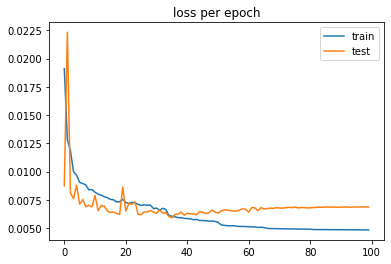

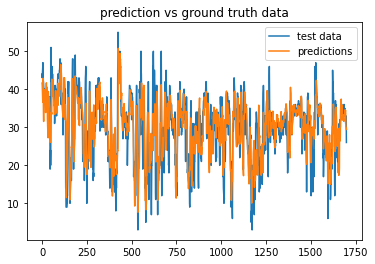

the mean squared error between the test data set and the predictions is : 0.005053789728734523


In [11]:
path = "C:/Users/jeffm/Desktop/projet_breezo"
city = "niigata"
particle = "o3"

S = Solution(path, city, particle)
S.prepare_features(use_features=True)
S.train(load=True)
S.test()
S.plot_data()


## Building a comparison model

Finally, I needed a comparison for my model.
I looked online and the ARIMA model which stands for AutoRegressive Integrated Moving Average seems to be a good working model for time series. Another model could have been the Prophet Facebook model.

ARIMA is an algorithm that takes into account 3 parameters and fit the model with the training data.
The first parameter is the number of previous values to take to fit the model. I wanted to take 24 like for the ML model, but the fitting was way too long, so I took 5 instead (for the ML model, the difference when taking 5 steps or 24 steps into account is not so important). <br>
The second parameter is a differentiating step that eliminates non stationarity. It seems that the data is stationary, so I set it to 0. <br>
The third and last parameter is the moving average. It takes into account errors made in the past to have a better precision. The parameter is exactly the number of errors in the past taken into account. I set it to 5 also to match the first parameter.


I am not an ARIMA expert and the model can probably be tuned better than this, but it gives a first intuition of the results and the computational time it takes.

In [70]:
class Solution():

    def __init__(self, path, city, particle):

        self._parse(path, city, particle)
        self._choose_file()
        self._load_data()

    def _parse(self, path, city, particle):# Specify the path to the met and stn files, 
                                            # the city to analyse and the particle to predict(all are strings).
                                            # In the python file, this is done with a real parser 
                                            # (see pollutant_inference.py)
            self.path, self.city, self.particle = path, city, particle 

    def _choose_file(self): # load the data paths according to the city

        if self.city == "niigata":
            self.name_met = "met_data/data_met_cams_jpn_niigata_15201220_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_niigata_15201220_pm25_o3.csv"
        elif self.city == "osaka":
            self.name_met = "met_data/data_met_cams_jpn_osaka_27227040_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_osaka_27227040_pm25_o3.csv"
        elif self.city == "tokyo":
            self.name_met = "met_data/data_met_cams_jpn_tokyo_13219010_met.csv"
            self.name_stn = "stn_data/data_stations_jpn_tokyo_13219010_pm25_o3.csv"
        elif self.city == "boston":
            self.name_met = "met_data/data_met_cams_usa_boston_250250042_met.csv"
            self.name_stn = "stn_data/data_stations_usa_boston_250250042_pm25_o3.csv"
        elif self.city == "los_angeles":
            self.name_met = "met_data/data_met_cams_usa_los_angeles_060371103_met.csv"
            self.name_stn = "stn_data/data_stations_usa_los_angeles_060371103_pm25_o3.csv"
        elif self.city == "pheonix":
            self.name_met = "met_data/data_met_cams_usa_pheonix_040139997_met.csv"
            self.name_stn = "stn_data/data_stations_usa_pheonix_040139997_pm25_o3.csv"
        else:
            raise os.error

    def _load_data(self): # load the data into the variables

        self.met = {} # met is a dictionnary that contains all the meteorological data

        with open(os.path.join(self.path, self.name_met)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader)
            for row in spamreader:
                row = row[1:] # first column is an irrelevant index
                row[1:] = list(map(float, row[1:]))
                self.met[row[0]] = row[1:] # the key is the date and the value is a list of the meteorological conditions 
                                            # [temperature, humidity, precipitation, radiation, wind speed, wind direction]


        o3 = [] # list of doubles : date + concentration of o3
        pm25 = [] # list of doubles : date + concentration of pm25
        with open(os.path.join(self.path, self.name_stn)) as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            next(spamreader) # skip first row that is only a header
            for row in spamreader:
                newrow = []
                row = row[1:5] # skip first column that is only an index
                newrow.append(row[0].split("+00:00")[0]) # split function is used to match the date format 
                                                            # with the dates of meteorological data
                newrow.append(float(row[1]))
                if row[3] == "True": # boolean that says if the data is valid
                    if row[2] == "o3":
                        o3.append(newrow)
                    if row[2] == "pm25":
                        pm25.append(newrow)
                else: # if the data is not valid
                    if row[2] == "o3":
                        newrow[1] = o3[-1][1] # we duplicate the last value (best estimation we have)
                        o3.append(newrow)
                    if row[2] == "pm25":
                        newrow[1] = pm25[-1][1]
                        pm25.append(newrow)


        self.pollutants = {"o3": pd.DataFrame(o3, columns=["date", "concentration"]), # Dictionary that contains both o3 and pm25 data
                            "pm25": pd.DataFrame(pm25, columns=["date", "concentration"])}

    def prepare_features(self, train_prop=0.8, output_len=5, n_hours=24, use_features=True): # Prepare the features for the machine learning model

        self.use_features = use_features # boolean asking if the model takes the meteorological data in count or only the particle concentrations
        self.n_hours = n_hours # number of hours to take into account for the prediction (default is 24)
        self.output_len = output_len # number of hours to predict in the future (default is 5)

        self.data = np.array(self.pollutants[self.particle]["concentration"]) # data of the concentration of the particle
        times = np.array(self.pollutants[self.particle]["date"]) # times of the measures
        n = len(self.data)
        self.last_train = int(train_prop*n) # last index of the train set
                                                # train_prop is the proportion of training data

        self.normalizing_ratio = np.max(self.data)
        data = self.data/self.normalizing_ratio # normalizing the data

        outputs = [] # regroups the outputs : the 5 next concentrations at each time
        for i in range(n - output_len):
            output = [data[j] for j in range(i+1, i+output_len+1)]
            outputs.append(output)

        self.output_train = outputs[:self.last_train-output_len] # remove the last 5 predictions that are in the test set
        self.output_test = outputs[self.last_train:]

        if not use_features:
            self.train_features = data[:self.last_train - output_len] # since we predict 5 steps ahead, we can't predict the 5 last steps
            self.test_features = data[self.last_train:n-output_len] # same here
            self.n_features = 1 # only predict with air pollution

        else:
            features = []
            for i in range(n):
                feature = self.met[times[i]] # all the meteorological conditions
                feature.append(data[i]) # append the air pollution
                features.append(feature)

            features = features / np.max(features, axis=0) # normalizing the features

            self.train_features = features[:self.last_train-output_len] # split train and tes features
            self.test_features = features[self.last_train:len(features)-output_len]

            self.n_features = len(feature)



    def train(self, load=False, batch_size=16, units=100, epochs=100): # train the ML model
                                                                        # batch size is the number of inputs fed at the same time
                                                                        # units is the number of neurons in the LSTM network

        self.load = load # load is a boolean that specify if we want to load a previous model

        if not load:

            self.generator_train = TimeseriesGenerator(self.train_features, self.output_train, length=self.n_hours, batch_size=batch_size) # generates the couples (input, output) for the time serie
            self.generator_test = TimeseriesGenerator(self.test_features, self.output_test, length=self.n_hours, batch_size=1)              # split between train and test


            model = Sequential() # initialize a neural network
            model.add(LSTM(units, activation='relu', input_shape=(self.n_hours, self.n_features))) # long short term memory layer : efficient for time series
            model.add(Dense(self.output_len)) # converge to the number of expected outputs

            model.compile(optimizer='Adam', loss="mse") # classic optimizer and loss

            model.summary()

            mcp_save = ModelCheckpoint(os.path.join(self.path, "model"), save_best_only=True, monitor='val_loss', mode='min') # save the best model according to validation loss
            reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, verbose=1, min_delta=1e-4, mode='min') # reduce learning rate if the loss hasn't decreased for too long

            model.fit(self.generator_train, validation_data = self.generator_test, epochs=epochs, callbacks=[mcp_save, reduce_lr_loss]) # train model

            with open(os.path.join(self.path, "model",'loss_history'), 'wb') as file_pi:
                pickle.dump(model.history.history, file_pi) # save loss history

            

        self.model = load_model(os.path.join(self.path, "model")) # load best model
        loss_history = pickle.load(open(os.path.join(self.path, "model",'loss_history'), "rb")) # load loss history
        self.train_loss = loss_history['loss']
        self.val_loss = loss_history['val_loss']

    def test(self): # predict the test outputs

        test_predictions = [] # collect predictions

        for i in range(0, len(self.test_features)-self.n_hours, self.output_len): # predict every 5 values

            current_batch = self.test_features[i:self.n_hours+i].reshape((1, self.n_hours, self.n_features)) #reshape to adapt to model

            current_pred = self.model.predict(current_batch)[0]

            test_predictions.extend(current_pred)

        self.test_predictions = test_predictions[:len(self.test_features)-self.n_hours] # can't match the final predictions that go outside the timing range

        
    def plot_data(self): # plot all the graphs
        plt.plot(self.train_loss, label='train') # train loss
        plt.plot(self.val_loss, label='test') # val loss
        plt.legend()
        plt.title("loss per epoch")
        plt.show()

        if self.use_features:
            plt.plot(np.multiply(self.test_features[self.n_hours:,self.n_features-1], self.normalizing_ratio), label="test data") # re multiply to have the real order of magnitude
            error = mean_squared_error(self.test_features[self.n_hours:,self.n_features-1],self.test_predictions) # mean squared error between predictions and outputs
        else:
            plt.plot(np.multiply(self.test_features[self.n_hours:], self.normalizing_ratio), label="test data")
            error = mean_squared_error(self.test_features[self.n_hours:],self.test_predictions)

        plt.plot(np.multiply(self.test_predictions, self.normalizing_ratio), label="predictions")
        plt.legend()
        plt.title("prediction vs ground truth data")
        plt.show()

        print("the mean squared error between the test data set and the predictions is :", error)
  
    def arima(self): # classic arima model

        self.train_arima = self.data[:self.last_train] # training set does not exclude the 5 last values
        self.test_arima = self.data[self.last_train:]

        self.history = [x for x in self.train_arima] # history used to fit the model
        self.arima_predictions = [] # collects predictions

        for i in range(0, len(self.test_arima), self.output_len):
            model = ARIMA(self.history, order=(5,0,5)) # create the arima model
            model_fit = model.fit() # train the arima model
            output = model_fit.forecast(self.output_len) # predict the next 5 outputs
            self.arima_predictions.extend(output)
            obs = self.test_arima[i:i+self.output_len]
            self.history.extend(obs) # history extends
            
    def plot_arima(self):

        plt.plot(self.test_arima, label="test data")
        plt.plot(self.arima_predictions, label="arima predictions")
        plt.legend()
        plt.title("ARIMA predictions vs ground truth test data")
        plt.show()

        error = mean_squared_error(self.test_arima/self.normalizing_ratio, self.arima_predictions/self.normalizing_ratio)

        print("For the ARIMA model, the mean squared error between the test data set and the predictions is :", error)

In [71]:
path = "C:/Users/jeffm/Desktop/projet_breezo"
city = "niigata"
particle = "o3"

S = Solution(path, city, particle)
S.prepare_features(use_features=False)
S.arima()
S.plot_arima()


c:\users\jeffm\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\jeffm\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\jeffm\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\jeffm\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\jeffm\miniconda3\lib\site-

KeyboardInterrupt: 

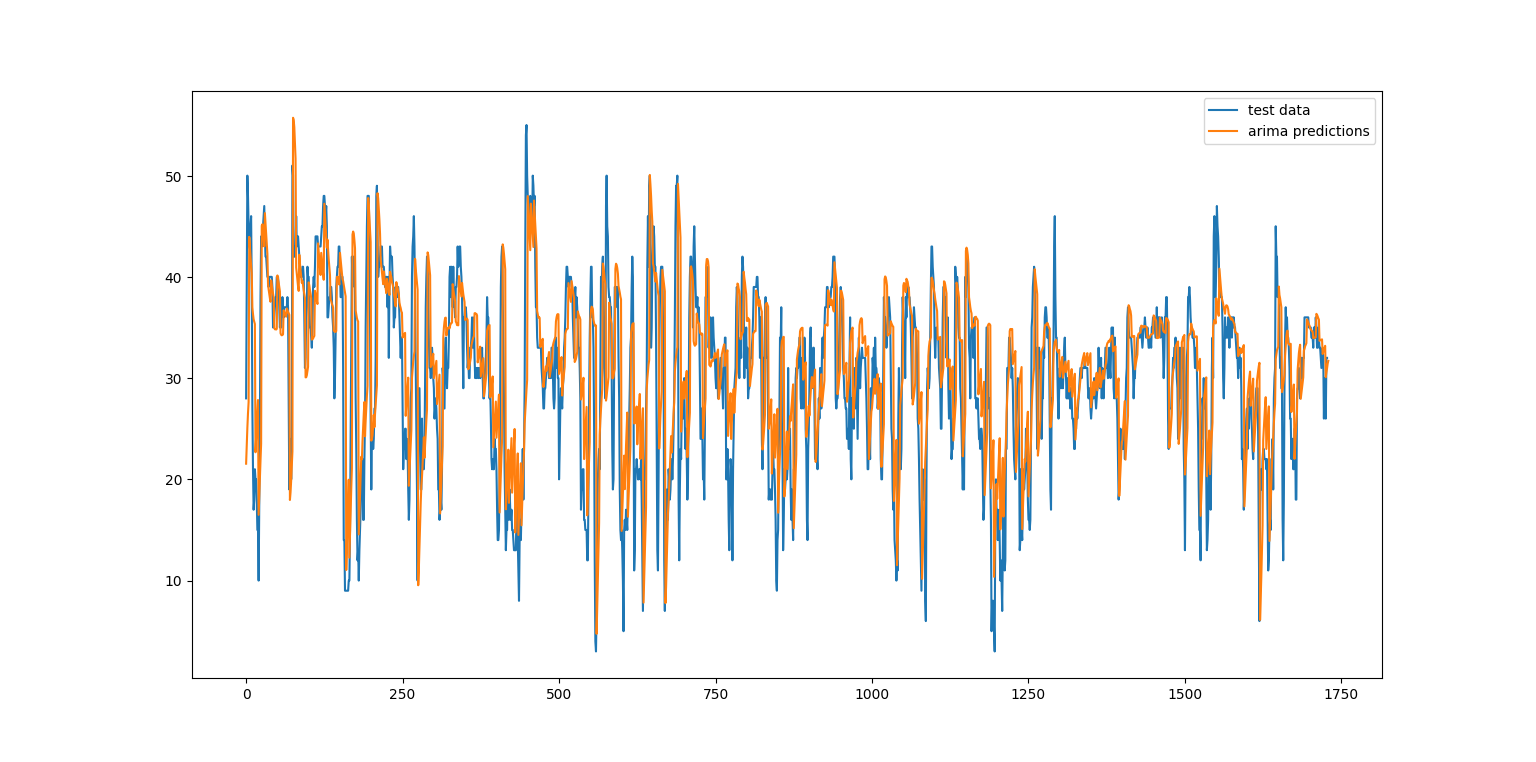

I uploaded an image of the Arima predictions because it takes a lot of time to compute.

Without zooming in, somtimes, the predictions seem very efficient but we can notice that they have a slight delay with the ground truth data meaning the model might rely too much on the previous value

## Conclusion

To sum up, this ML model seems to be fitting quite well the data :

For example, for Niigata and o3 the mse loss (for the .py file) is : <br>
For ARIMA : 0.007 <br>
For ML model without meteorological data : 0.006 <br>
For ML model with meteorological data : 0.005 <br>

Furthermore, the ARIMA model seems to be very long to compute and harder to fine tune.
However, I am not as familiar with this model as with ML model, so it's possible that I missed an important aspect.


The improvements I mentioned are :

- fill the invalid data with a "pre-model" that would only use the meteorological data.
- split the validation data into validation and test to avoid overfitting the hyperparameters
- split the data into weeks or months and randomly asign them to training and validation to avoid biases
- compute the precision for each future time step : t+1, t+2, ... instead of a general precision over all time steps
- Improve the ARIMA model to take into account the meteorological data
- Try other "classical models" such as Prophet
- Try other types of ML models or add other layers although if it might complicate the model too much 


- possibly include the meteorological data of future time steps if we consider that they don't suffer the "lag" problem that the pollution stations have. <br > 
Maybe this will show an improvement for the pm25 predictions (I recall that for now meteorological data don't improve the predictions for pm25)
- check if the two pollutants' concentrations have correlations between each other